### Experiment 2 - Table 2

Calculating test accuracy and robustness (adversarial accuracy, adv. acc) for different datasets and different settings, given Trimmed mean and median aggregation schemes

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from utils.util_notebooks import set_args, import_model_weights, get_adv_acc
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *


/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 20
exp = "fakenewsnet"

# Load models for FAT and FedAvg - write down path to where weights are saved
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 0.1
eps_train = 0.2
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:02<00:00,  8.91it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:01<00:00, 16.98it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(tor

In [6]:
# Take measurement for ARU attack
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregation_op = 'trimmed_mean'
aggregator.op = aggregation_op
weight_scale_2 = 1
atk_rounds = 1
tm_beta = 0.05

if False:
    print("updating adv data set")

    # add adv dataset update - have last 15 clients generate adv examples 
    Fu = np.ones(num_user)
    Fu[25:] = 0

    # Setting evasion attack parameters
    x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
    x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = steps,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = step_size, step_norm = "inf", eps = eps_train, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(aggregator.clients)):
        if Fu[c] > 0:
            # print (c)
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()

            aggregator.clients[c].assign_advdataset()


for i in range(atk_rounds):
    print('round ', i)
    UNL_mix(aggregator, adv_id=[0], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op, tm_beta = tm_beta)


model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("TRIMMED MEAN")
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
trimmed mean, N removed:  1
weight scale: 
 [18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00
 18.00 18.00 18.00 18.00 18.00 18.00 18.00 18.00]


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


TRIMMED MEAN
Test acc:  0.6971428573131562  ( 0.07445036642699503 )  adv acc:  0.3692857213318348  ( 0.060318032633704916 ) 


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Submodule Name                 Mean Cosine Similarity         Std Dev
conv1                                    0.99998933      0.00000010 
conv2                                    0.96397662      0.00052369 
conv3                                    0.93490654      0.00153739 !!!
fc1                                      0.70274884      0.04830325 !!!
fc2                                      0.34229782      0.44475055 !!!


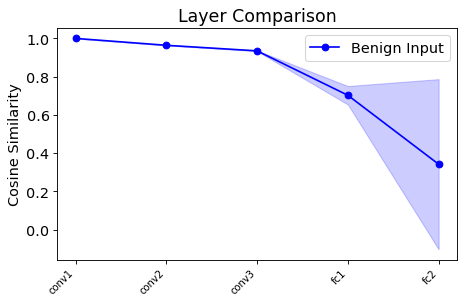

In [7]:
dataloader = load_client_data(clients = aggregator.clients, c_id = 0, mode = 'test')
x_data = dataloader.x_data.to(torch.float32)
y_data = dataloader.y_data
# Example usage
# labs1, cs1 , std_dev1= compare_top_level_outputs_with_cosine_similarity(model_overfit, model_Fedavg, x_data.cuda())
labs1, cs1 , std_dev1= compare_top_level_outputs_with_cosine_similarity_fnn(model_overfit, model_Fedavg, x_data.cuda())
# Plotting setup
font = {'family': 'normal', 'weight': 'normal', 'size': 13}
threshold = 0.95

# Set font and figure size
plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot Cosine Similarities for both sets of inputs
line_color1 = 'b'  # Color for benign input
line_color2 = 'r'  # Color for adversarial input

plt.plot(labs1, cs1, marker="o", color=line_color1, label="Benign Input")

# Overlay standard deviation ranges with matching colors
plt.fill_between(labs1, 
                 np.array(cs1) - std_dev1, 
                 np.array(cs1) + std_dev1, 
                 color=line_color1, alpha=0.2)


# Add threshold line (optional)
# plt.axhline(y=threshold, color="r", linestyle="--", label=f"Threshold = {threshold}")

# Plot settings
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Cosine Similarity")
plt.title("Layer Comparison")
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
# Take measurement for ARU attack
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregator.op = None
weight_scale_2 = 1
atk_rounds = 1
aggregation_op = 'median'

for i in range(atk_rounds):
    print('round ', i)
    UNL_mix(aggregator, adv_id=[0], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op)

model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("MEDIAN")
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
MEDIAN
Test acc:  0.6700000062584877  ( 0.07254836334162194 )  adv acc:  0.3857142925262451  ( 0.05458563438799332 ) 
